In [46]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import numpy as np

# BioInformatica #2

## Data Spliting

In [20]:
df_X = pd.read_csv('X_gexp.csv')
df_Y = pd.read_csv('y_gexp.csv')
df_X.drop(columns=["Unnamed: 0"],inplace=True)
df_Y.drop(columns=["Unnamed: 0"],inplace=True)
df_X.head()

,FSTL1,ELMO2,CREB3L1,PNMA1,MMP2,SMARCD3,PKNOX2,RALYL,ZHX3,APBB2,...,ST18,PSMB9,ProSAPiP1,HCLS1,MMP9,KIAA0802,DHRS2,SGEF,PIK3IP1,CTSC
0,2.275179,1.873549,1.772059,2.144198,2.269443,1.742389,1.797055,1.677848,1.801352,1.786488,...,1.669895,2.346811,2.004333,2.213310,2.407606,2.083333,2.098461,1.680092,1.953595,2.429578
1,2.569520,2.085888,1.961846,2.315705,2.505400,2.226593,1.798769,1.671170,2.000942,2.089285,...,1.516024,2.339930,2.045828,2.285701,2.633632,1.938474,1.614437,1.760419,2.010156,2.431814
2,2.471492,2.030865,1.845808,2.072279,2.346815,1.783762,1.707150,1.599492,1.823480,1.778307,...,1.527561,2.302006,2.059862,2.130193,2.349831,1.815239,1.857933,1.675823,2.011970,2.434026
3,2.464403,2.094165,1.762169,2.374129,2.213562,2.209426,1.925440,1.936043,2.003743,2.024847,...,1.611626,2.208924,2.050555,2.213955,1.982603,2.125508,1.631955,1.881003,1.886280,2.450704
4,2.365457,2.188070,1.763206,2.340024,2.219210,2.308335,1.801007,1.756726,2.115714,2.086733,...,1.570489,2.187420,2.265522,2.192262,1.796491,1.979615,1.637215,2.182186,1.897957,2.140727


In [21]:
df_X.shape

(302, 5000)

In [22]:
df_X.isna().sum()

FSTL1       0
ELMO2       0
CREB3L1     0
PNMA1       0
MMP2        0
           ..
KIAA0802    0
DHRS2       0
SGEF        0
PIK3IP1     0
CTSC        0
Length: 5000, dtype: int64

In [38]:
df_Y.head()

,x
0,0
1,1
2,0
3,0
4,0


## Data Pre Processing

In [23]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_X)

## Feature selection

Minimal Variance Treshold:

* Removes low-variance features (assumes features are on the same scale).

* If features are not scaled, variance will be biased toward features with larger magnitudes.

* Needs StandardScaler before applying.

The treshold means ....., and by increasing this hyperparanter the number of features decreases.

In [ ]:
variance = VarianceThreshold(threshold=1.0) 
X_filtered = variance.fit_transform(X_scaled)
selected_features_variance = df_X.columns[variance.get_support()]
print("Selected features:", selected_features_variance)

Selected features: Index(['FSTL1', 'PNMA1', 'BBOX1', 'EDN1', 'CRNKL1', 'BANK1', 'NR4A2',
       'MAP1LC3C', 'SLCO2B1', 'ANKRD6',
       ...
       'GAB1', 'CP', 'G6PC3', 'NDUFS7', 'S100A13', 'RPS6KA3', 'DACT1', 'EAF2',
       'HCLS1', 'PIK3IP1'],
      dtype='object', length=981)


Principal Component Analysis (PCA)

* PCA is variance-based and highly sensitive to feature scales.

* Needs StandardScaler before applying.

In [41]:
pca = PCA(n_components=0.99, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Number of components kept:", pca.n_components_)

Explained variance ratio: [0.20340018 0.11477919 0.07821268 0.03545906 0.0308693  0.02112771
 0.02090315 0.01875553 0.01597494 0.01560346 0.01439048 0.01384711
 0.0110561  0.00981724 0.00974779 0.00868764 0.00824579 0.00797324
 0.00761317 0.00741741 0.00706661 0.0066442  0.00651056 0.00623483
 0.00584102 0.00566617 0.00553621 0.00515573 0.00507862 0.00483169
 0.00461656 0.00459624 0.00444038 0.00430193 0.00400767 0.00393192
 0.00386651 0.00384336 0.00365156 0.00357042 0.00350832 0.00345822
 0.0033634  0.00324607 0.00308716 0.00304122 0.00294507 0.00287947
 0.00283553 0.0027914  0.00275843 0.00271642 0.00266701 0.00261579
 0.00255127 0.00254202 0.00246241 0.00241631 0.00237861 0.00229144
 0.00226327 0.00225421 0.00219408 0.00216979 0.00215688 0.00212784
 0.00208422 0.00201147 0.00197534 0.00195987 0.00193366 0.00189545
 0.00186948 0.00184815 0.00179394 0.00177606 0.00175101 0.00171196
 0.00168939 0.00167262 0.00164485 0.00163102 0.00162419 0.00157123
 0.00155399 0.00153307 0.00151156 0.

Clustering-based Methods (if used for feature selection)

* Methods like K-means rely on Euclidean distance, which is scale-dependent.

* Needs StandardScaler before applying.

In [ ]:
#idk bro

ANOVA F-test

* Measures the relationship between each feature and the target variable (categorical).

* Based on variance ratios, not absolute values.

* Does not need StandardScaler.

In [ ]:
k = 500 
anova = SelectKBest(score_func=f_classif, k=k)
X_selected = anova.fit_transform(df_X, df_Y)

selected_features_anova = df_X.columns[anova.get_support()]
print("Selected Features:", selected_features_anova)

Selected Features: Index(['POMT1', 'HK3', 'CAMK2B', 'FOLR2', 'FPR1', 'EGFR', 'ACSL1', 'HIP1R',
       'SLC7A7', 'IL10RA',
       ...
       'DKK1', 'OLFML2B', 'ARC', 'RAB27A', 'ASCL1', 'UAP1', 'VAV1', 'CSF2RB',
       'SGEF', 'CTSC'],
      dtype='object', length=150)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Correlation with the Target Variable

* Does not use StandardScaler

In [ ]:
correlation_matrix = pd.concat([df_X, df_Y], axis=1).corr()
target_correlation = correlation_matrix[df_Y.columns[0]].abs().sort_values(ascending=False)
selected_features_correlation = target_correlation.drop(df_Y.columns[0])

print("Top correlated features:")
print(selected_features_correlation.head(20))

Top correlated features:
CSTA       0.638624
TNFAIP8    0.636948
BCAN       0.629344
CTSC       0.626365
ARPC1B     0.622097
SLAMF8     0.603908
IL1R1      0.602104
IFI30      0.588972
RAB27A     0.585345
GAS1       0.581443
EGFR       0.581213
PLAUR      0.576623
WSCD1      0.574798
CSPG5      0.574032
OLIG2      0.573298
MAP3K8     0.572961
SEZ6L      0.571512
GCNT1      0.569868
ARC        0.568681
LY96       0.565789
Name: x, dtype: float64


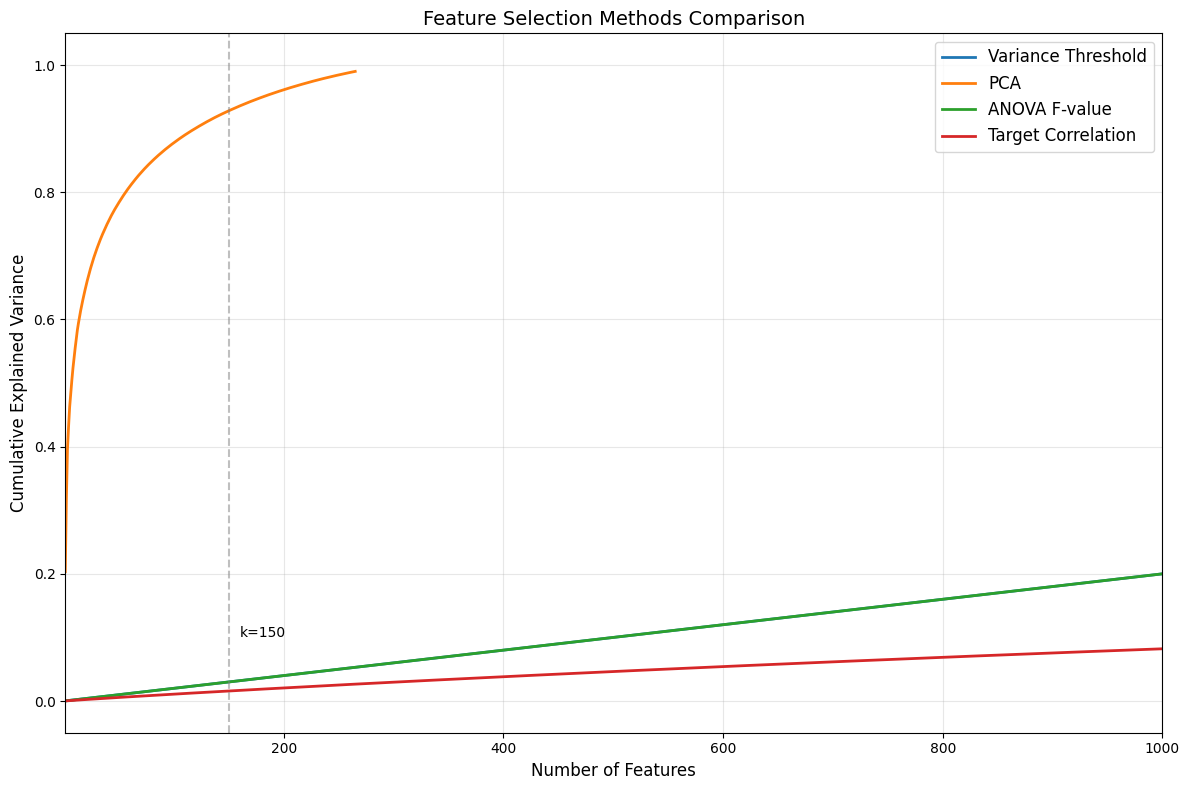

In [ ]:
# Create a figure
plt.figure(figsize=(12, 8))

# 1. For VarianceThreshold - we'll plot cumulative variance explained vs features kept
# (Note: VarianceThreshold doesn't directly give explained variance, so we'll use the remaining features' variance)
variances = np.var(X_scaled, axis=0)
sorted_variances = np.sort(variances)[::-1]
cumulative_variance = np.cumsum(sorted_variances) / np.sum(variances)
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, 
         label='Variance Threshold', linewidth=2)

# 2. For PCA - we already have explained_variance_ratio_
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_), 
         label='PCA', linewidth=2)

# 3. For ANOVA - we can calculate cumulative explained variance of top k features
anova_scores = anova.scores_
sorted_indices = np.argsort(anova_scores)[::-1]
sorted_variances_anova = variances[sorted_indices]
cumulative_variance_anova = np.cumsum(sorted_variances_anova) / np.sum(variances)
plt.plot(range(1, len(cumulative_variance_anova)+1), cumulative_variance_anova,
         label='ANOVA F-value', linewidth=2)

# 4. For Correlation - similar approach to ANOVA
cumulative_variance_corr = np.cumsum(target_correlation) / np.sum(variances)
plt.plot(range(1, len(cumulative_variance_corr)+1), cumulative_variance_corr,
         label='Target Correlation', linewidth=2)

# Add vertical line for your selected k in ANOVA
plt.axvline(x=k, color='gray', linestyle='--', alpha=0.5)
plt.text(k+10, 0.1, f'k={k}', rotation=0)

# Customize plot
plt.xlabel('Number of Features', fontsize=12)
plt.ylabel('Cumulative Explained Variance', fontsize=12)
plt.title('Feature Selection Methods Comparison', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.xlim(1, min(1000, len(variances)))
plt.tight_layout()
plt.show()

## Model training

### Unsupervised Learning

### Supervised Learning

## Model testing